# Import and merge

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Directory with CSVs
csv_dir = '/content/'

# 2. List all CSV files
csv_files = [f for f in os.listdir(csv_dir) if f.endswith('.csv')]

# 3. Desired PIDs
final_pids = [
    'RPM', 'THROTTLE_POS', 'SPEED', 'FUEL_PRESSURE', 'ENGINE_LOAD',
    'COOLANT_TEMP', 'INTAKE_TEMP', 'TIMING_ADVANCE', 'MAF', 'INTAKE_PRESSURE',
    'SHORT_FUEL_TRIM_1', 'LONG_FUEL_TRIM_1', 'SHORT_FUEL_TRIM_2', 'LONG_FUEL_TRIM_2',
    'COMMANDED_EQUIV_RATIO', 'O2_B1S2', 'O2_B2S2', 'O2_S1_WR_VOLTAGE', 'COMMANDED_EGR'
]
columns_to_keep = ['timestamp'] + final_pids

# 4. Merge PID data
pid_dfs = []
for fname in csv_files:
    df = pd.read_csv(os.path.join(csv_dir, fname))
    df = df[[c for c in columns_to_keep if c in df.columns]]
    pid_dfs.append(df)

merged_df = pd.concat(pid_dfs, ignore_index=True)
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'], errors='coerce')
merged_df = merged_df.sort_values('timestamp').dropna(subset=['timestamp'])
merged_df = merged_df.drop_duplicates(subset='timestamp', keep='first')

print("=== Merged PID Data ===")
print(merged_df.shape)
display(merged_df.head())

# 5. Merge driving_style metadata
meta_dfs = []
for fname in csv_files:
    df = pd.read_csv(os.path.join(csv_dir, fname))
    if 'timestamp' in df.columns and 'driving_style' in df.columns:
        df = df[['timestamp', 'driving_style']].copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        # Normalize labels
        df['driving_style'] = df['driving_style'].replace({
            'UNKNOWN_STYLE': None,
            'mild': 'Moderate',
            'Moderate': 'Moderate',
            'Passive': 'Passive',
            'passive': 'Passive',
            'IDLE': 'idle',
            'Idle': 'idle'
        })
        meta_dfs.append(df)

meta_df = pd.concat(meta_dfs, ignore_index=True)
meta_df = meta_df.sort_values('timestamp').dropna(subset=['timestamp'])
meta_df = meta_df.drop_duplicates(subset='timestamp', keep='first')

# Merge metadata
merged_df = pd.merge(merged_df, meta_df, on='timestamp', how='left')

# 6. Save merged CSV
merged_csv_path = os.path.join(csv_dir, 'merged.csv')
merged_df.to_csv(merged_csv_path, index=False)
print(f"✅ Saved merged CSV → {merged_csv_path}")

# 7. Filter rows with at least one PID
mask_any_pid = merged_df[final_pids].notnull().any(axis=1)
cleaned_df = merged_df[mask_any_pid].copy()
cleaned_df = cleaned_df.sort_values('timestamp').drop_duplicates(subset='timestamp', keep='first')

# 8. Add time differences
cleaned_df['timestamp'] = pd.to_datetime(cleaned_df['timestamp'], errors='coerce')
cleaned_df = cleaned_df.sort_values('timestamp').reset_index(drop=True)
cleaned_df['time_diff'] = cleaned_df['timestamp'].diff().dt.total_seconds()

# 9. Add new_session
session_gap_threshold = 3600  # 1 hour for idle detection
cleaned_df['new_session'] = (cleaned_df['time_diff'] > session_gap_threshold).cumsum()

# ✅ 9.1 Detect continuous idle periods (SPEED == 0 for >= 5 minutes)
cleaned_df['speed_zero'] = (cleaned_df['SPEED'] == 0)
cleaned_df['speed_zero_shift'] = cleaned_df['speed_zero'].shift(1, fill_value=False)
cleaned_df['run_start'] = cleaned_df['speed_zero'] != cleaned_df['speed_zero_shift']
cleaned_df['run_id'] = cleaned_df['run_start'].cumsum()

# Group by run_id to get durations
run_info = cleaned_df.groupby('run_id').agg(
    speed_zero=('speed_zero', 'first'),
    start_time=('timestamp', 'first'),
    end_time=('timestamp', 'last')
)
run_info['duration_sec'] = (run_info['end_time'] - run_info['start_time']).dt.total_seconds()

# Label rows where speed_zero is True and duration >= 300 seconds (5 minutes)
idle_runs = run_info[(run_info['speed_zero']) & (run_info['duration_sec'] >= 60)]
for rid in idle_runs.index:
    cleaned_df.loc[cleaned_df['run_id'] == rid, 'driving_style'] = 'idle'

# Drop helper columns
cleaned_df.drop(columns=['speed_zero', 'speed_zero_shift', 'run_start', 'run_id'], inplace=True)

# Save cleaned.csv
cleaned_csv_path = os.path.join(csv_dir, 'cleaned.csv')
cleaned_df.to_csv(cleaned_csv_path, index=False)
print(f"✅ Saved cleaned CSV → {cleaned_csv_path}")

# Save cleaned_with_style.csv (after idle logic)
with_style_df = cleaned_df.dropna(subset=['driving_style']).copy()
with_style_df = with_style_df.sort_values('timestamp').drop_duplicates(subset='timestamp', keep='first')

with_style_csv_path = os.path.join(csv_dir, 'cleaned_with_style.csv')
with_style_df.to_csv(with_style_csv_path, index=False)
print(f"✅ Saved cleaned_with_style CSV → {with_style_csv_path}")

# Final check
print("\n=== Final DataFrame with Sessions ===")
print(cleaned_df.shape)
display(cleaned_df.head())
display(cleaned_df.head())


=== Merged PID Data ===
(44552, 20)


,timestamp,RPM,THROTTLE_POS,SPEED,FUEL_PRESSURE,ENGINE_LOAD,COOLANT_TEMP,INTAKE_TEMP,TIMING_ADVANCE,MAF,INTAKE_PRESSURE,SHORT_FUEL_TRIM_1,LONG_FUEL_TRIM_1,SHORT_FUEL_TRIM_2,LONG_FUEL_TRIM_2,COMMANDED_EQUIV_RATIO,O2_B1S2,O2_B2S2,O2_S1_WR_VOLTAGE,COMMANDED_EGR
10363,2025-05-21 09:52:47.807480,1909.25,23.529412,27.0,54.0,22.352941,39.0,13.0,23.0,48.32,68.0,1.5625,1.5625,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824
10364,2025-05-21 09:52:52.095349,2211.50,22.745098,40.0,54.0,22.352941,39.0,13.0,23.0,48.32,68.0,1.5625,1.5625,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824
10365,2025-05-21 09:52:52.600291,2284.75,24.705882,42.0,54.0,22.352941,39.0,13.0,23.0,48.32,68.0,1.5625,1.5625,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824
10366,2025-05-21 09:52:53.104128,2434.50,24.705882,44.0,54.0,22.352941,39.0,13.0,23.0,48.32,68.0,1.5625,1.5625,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824
10367,2025-05-21 09:52:53.609186,2533.50,25.098039,46.0,54.0,22.352941,39.0,13.0,23.0,48.32,68.0,1.5625,1.5625,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824


<ipython-input-1-f45f6749c832>:43: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')


✅ Saved merged CSV → /content/merged.csv
✅ Saved cleaned CSV → /content/cleaned.csv
✅ Saved cleaned_with_style CSV → /content/cleaned_with_style.csv

=== Final DataFrame with Sessions ===
(41114, 23)


,timestamp,RPM,THROTTLE_POS,SPEED,FUEL_PRESSURE,ENGINE_LOAD,COOLANT_TEMP,INTAKE_TEMP,TIMING_ADVANCE,MAF,...,SHORT_FUEL_TRIM_2,LONG_FUEL_TRIM_2,COMMANDED_EQUIV_RATIO,O2_B1S2,O2_B2S2,O2_S1_WR_VOLTAGE,COMMANDED_EGR,driving_style,time_diff,new_session
0,2025-05-21 09:52:47.807480,1909.25,23.529412,27.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,NaN,0
1,2025-05-21 09:52:52.095349,2211.50,22.745098,40.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,4.287869,0
2,2025-05-21 09:52:52.600291,2284.75,24.705882,42.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.504942,0
3,2025-05-21 09:52:53.104128,2434.50,24.705882,44.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.503837,0
4,2025-05-21 09:52:53.609186,2533.50,25.098039,46.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.505058,0


,timestamp,RPM,THROTTLE_POS,SPEED,FUEL_PRESSURE,ENGINE_LOAD,COOLANT_TEMP,INTAKE_TEMP,TIMING_ADVANCE,MAF,...,SHORT_FUEL_TRIM_2,LONG_FUEL_TRIM_2,COMMANDED_EQUIV_RATIO,O2_B1S2,O2_B2S2,O2_S1_WR_VOLTAGE,COMMANDED_EGR,driving_style,time_diff,new_session
0,2025-05-21 09:52:47.807480,1909.25,23.529412,27.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,NaN,0
1,2025-05-21 09:52:52.095349,2211.50,22.745098,40.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,4.287869,0
2,2025-05-21 09:52:52.600291,2284.75,24.705882,42.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.504942,0
3,2025-05-21 09:52:53.104128,2434.50,24.705882,44.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.503837,0
4,2025-05-21 09:52:53.609186,2533.50,25.098039,46.0,54.0,22.352941,39.0,13.0,23.0,48.32,...,0.0,1.5625,0.140544,0.76,0.86,2.448524,7.058824,None,0.505058,0


# Processing

In [ ]:
import pandas as pd

# Load the cleaned_with_style.csv
df = pd.read_csv('/content/cleaned_with_style.csv')

# Count how many rows have driving_style == 'idle'
idle_count = (df['driving_style'] == 'idle').sum()
total_count = len(df)

print(f"🟡 Idle rows: {idle_count}")
print(f"📊 Total rows with labeled driving_style: {total_count}")
print(f"📈 Idle proportion: {idle_count / total_count:.2%}")


🟡 Idle rows: 3318
📊 Total rows with labeled driving_style: 39609
📈 Idle proportion: 8.38%


<ipython-input-7-8c66e95c96b9>:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_features = df_features.fillna(method='ffill').dropna()


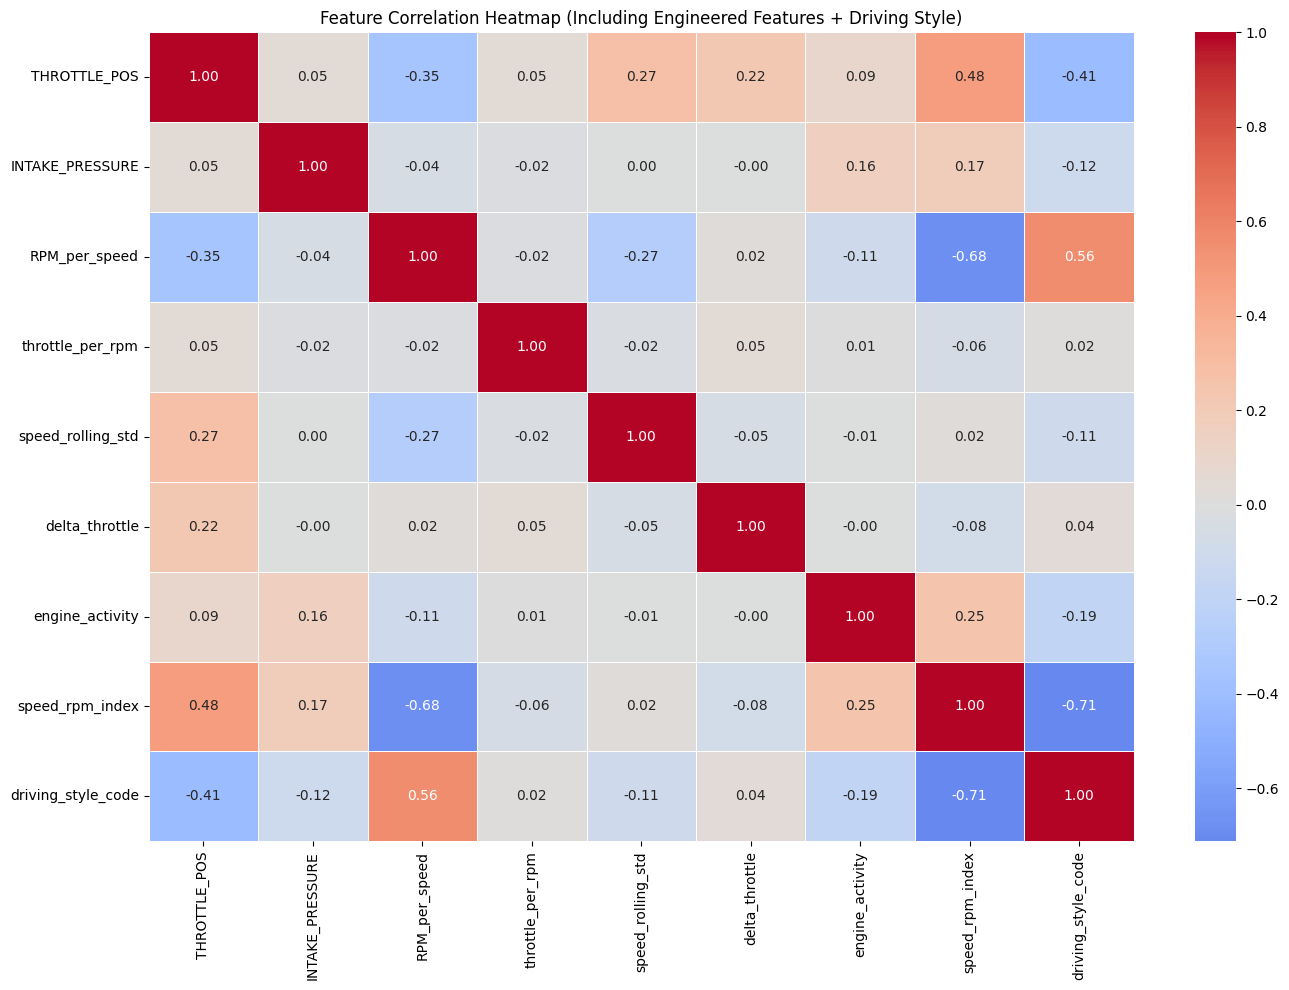

✅ Engineered features with driving_style saved to 'featured_engineering.csv'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Load your cleaned data with driving style
df = pd.read_csv('/content/cleaned_with_style.csv')

# Use your selected features only
final_driver_features = [
    'RPM',
    'THROTTLE_POS',
    'SPEED',
    'ENGINE_LOAD',
    'MAF',
    'INTAKE_PRESSURE'
]

df_features = df[final_driver_features].copy()

# Fill missing values (forward fill and then drop any remaining NA)
df_features = df_features.fillna(method='ffill').dropna()

# --- Feature Engineering ---
# Ratio-based features
df_features['RPM_per_speed'] = df_features['RPM'] / (df_features['SPEED'] + 1e-3)
df_features['throttle_per_rpm'] = df_features['THROTTLE_POS'] / (df_features['RPM'] + 1e-3)

# Rolling window features (window=3 samples)
df_features['speed_rolling_std'] = df_features['SPEED'].rolling(window=3, min_periods=1).std().fillna(0)

# Derivatives (difference between consecutive rows)
df_features['delta_throttle'] = df_features['THROTTLE_POS'].diff().fillna(0)

# Combine ENGINE_LOAD and MAF into a new feature
df_features['engine_activity'] = df_features[['ENGINE_LOAD', 'MAF']].mean(axis=1)
# Drop original columns
df_features = df_features.drop(columns=['ENGINE_LOAD', 'MAF'])

# Combine SPEED and RPM using normalization to create a balanced index
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_features[['SPEED', 'RPM']])
df_features['speed_rpm_index'] = df_scaled.mean(axis=1)
# Drop original columns
df_features = df_features.drop(columns=['SPEED', 'RPM'])

# --- Add driving_style back for analysis and save ---
df_features['driving_style'] = df.loc[df_features.index, 'driving_style'].copy()

# Convert driving_style to category codes for correlation (optional)
df_features['driving_style_code'] = df_features['driving_style'].astype('category').cat.codes

# Compute correlation matrix (exclude non-numeric columns like strings)
corr = df_features.drop(columns=['driving_style']).corr()

# Display correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Feature Correlation Heatmap (Including Engineered Features + Driving Style)")
plt.tight_layout()
plt.show()

# Save the engineered features along with driving_style
df_features.to_csv('/content/featured_engineering.csv', index=False)
print("✅ Engineered features with driving_style saved to 'featured_engineering.csv'")

In [ ]:
import pandas as pd

# Load cleaned dataset
df = pd.read_csv('/content/cleaned_with_style.csv')

# Select only the final features + driving_style
final_driver_features = [
    'RPM',
    'THROTTLE_POS',
    'SPEED',
    'ENGINE_LOAD',

]

df_selected = df[final_driver_features + ['driving_style']].copy()

# Drop missing data if any
df_selected = df_selected.dropna()

# Save selected features dataset
df_selected.to_csv('/content/feature_selection.csv', index=False)

print(f"Saved feature selection dataset with {df_selected.shape[1]} columns (including driving_style).")


Saved feature selection dataset with 5 columns (including driving_style).


# Training

<ipython-input-9-0c6d9179ac2e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Selection Dataset ====
Silhouette Score: 0.420
Adjusted Rand Index (ARI): 0.157
Normalized Mutual Info (NMI): 0.262


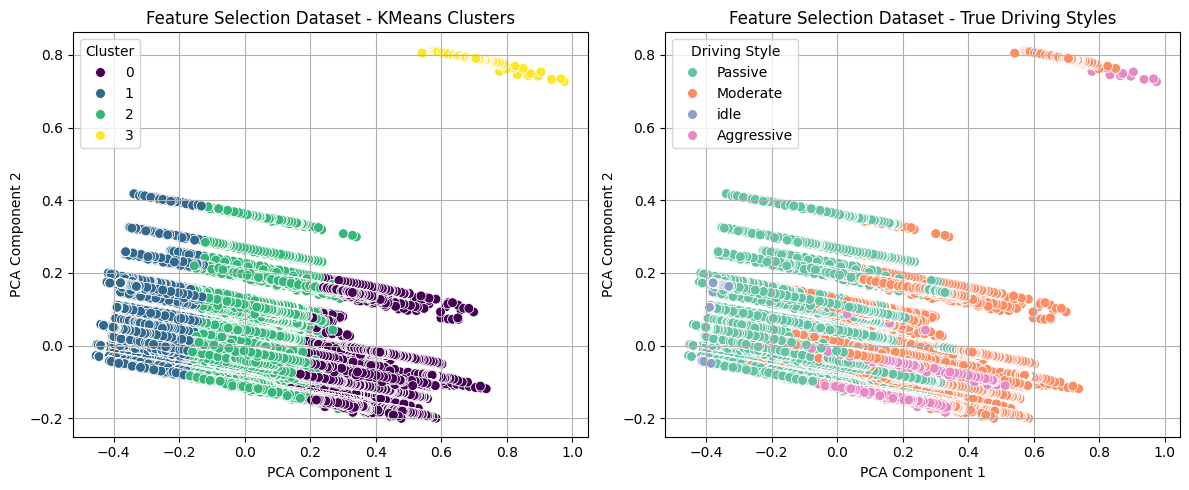

<ipython-input-9-0c6d9179ac2e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Engineering Dataset ====
Silhouette Score: 0.419
Adjusted Rand Index (ARI): 0.484
Normalized Mutual Info (NMI): 0.565


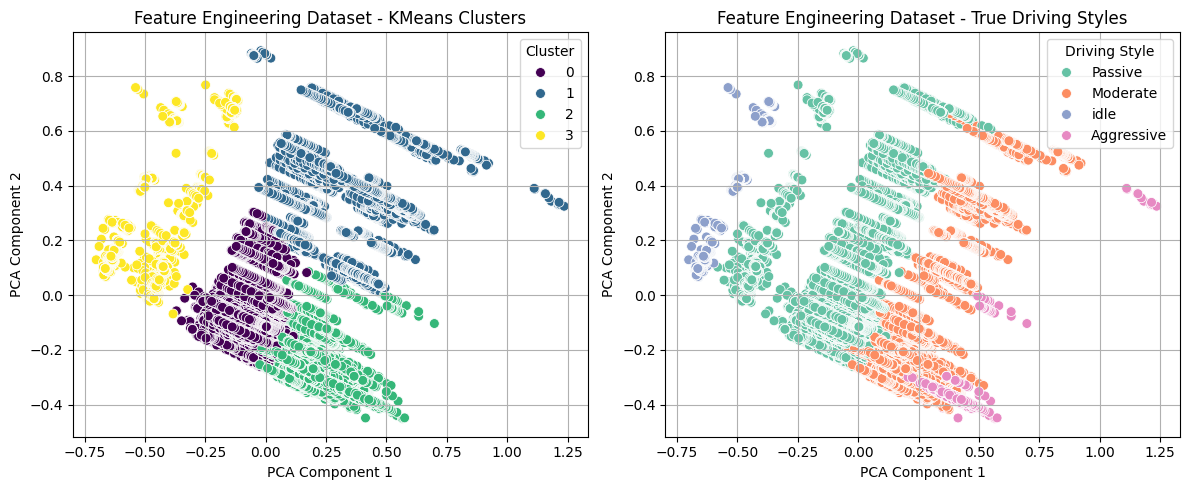

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_clustering(file_path, dataset_name, k=4):
    # Load dataset
    df = pd.read_csv(file_path)

    if 'driving_style' not in df.columns:
        raise ValueError("Dataset must include 'driving_style' column.")

    # Separate features and labels
    y_true = df['driving_style']
    X = df.drop(columns=['driving_style'])

    # Fill and drop missing values
    df_filled = X.fillna(method='ffill').dropna()
    X = df_filled
    y_true = y_true.loc[X.index].reset_index(drop=True)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Evaluation
    silhouette = silhouette_score(X_scaled, cluster_labels)
    ari = adjusted_rand_score(y_true, cluster_labels)
    nmi = normalized_mutual_info_score(y_true, cluster_labels)

    print(f"\n==== {dataset_name} ====")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.3f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    # Plot KMeans clusters
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title(f"{dataset_name} - KMeans Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)

    # Plot actual driving styles
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='Set2', s=50)
    plt.title(f"{dataset_name} - True Driving Styles")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Driving Style')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return for inspection
    df_result = X.copy()
    df_result['cluster'] = cluster_labels
    df_result['driving_style'] = y_true
    return df_result

# Run clustering on Feature Selection dataset
result_selection = run_clustering('/content/feature_selection.csv', 'Feature Selection Dataset')

# Run clustering on Feature Engineering dataset
result_engineering = run_clustering('/content/featured_engineering.csv', 'Feature Engineering Dataset')


<ipython-input-10-0c6d9179ac2e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Selection Dataset ====
Silhouette Score: 0.420
Adjusted Rand Index (ARI): 0.157
Normalized Mutual Info (NMI): 0.262


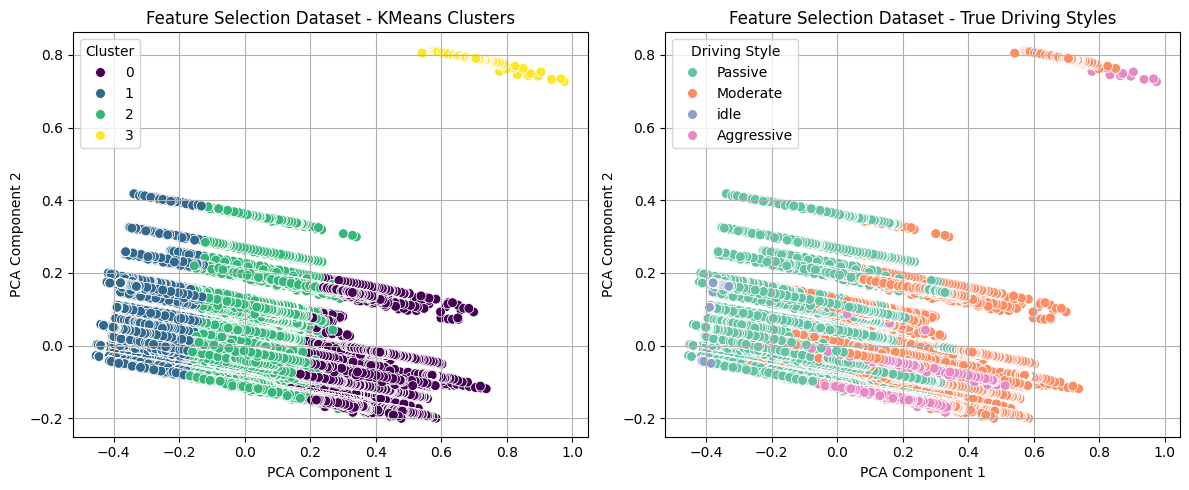

<ipython-input-10-0c6d9179ac2e>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Engineering Dataset ====
Silhouette Score: 0.419
Adjusted Rand Index (ARI): 0.484
Normalized Mutual Info (NMI): 0.565


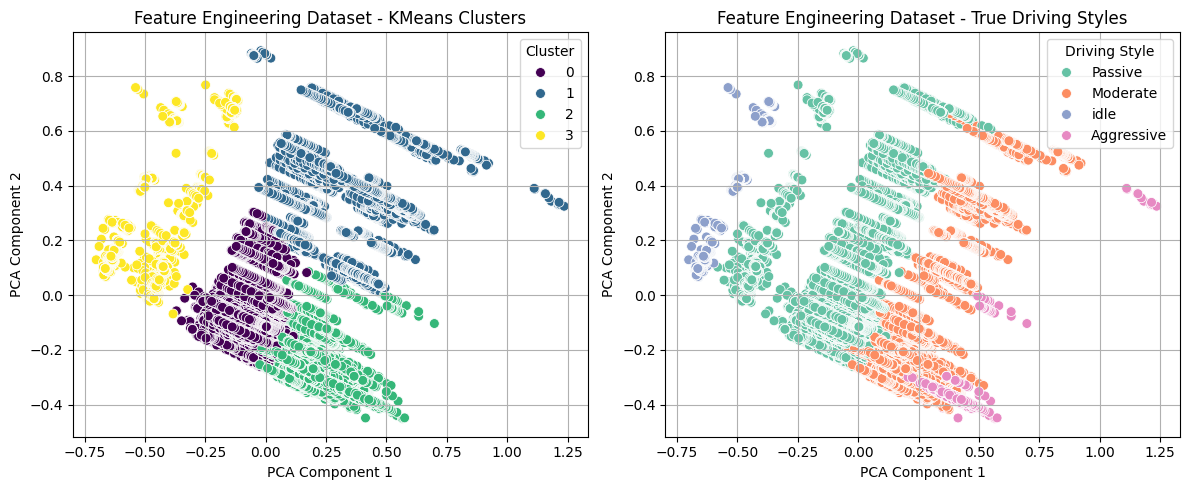

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_clustering(file_path, dataset_name, k=4):
    # Load dataset
    df = pd.read_csv(file_path)

    if 'driving_style' not in df.columns:
        raise ValueError("Dataset must include 'driving_style' column.")

    # Separate features and labels
    y_true = df['driving_style']
    X = df.drop(columns=['driving_style'])

    # Fill and drop missing values
    df_filled = X.fillna(method='ffill').dropna()
    X = df_filled
    y_true = y_true.loc[X.index].reset_index(drop=True)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Evaluation
    silhouette = silhouette_score(X_scaled, cluster_labels)
    ari = adjusted_rand_score(y_true, cluster_labels)
    nmi = normalized_mutual_info_score(y_true, cluster_labels)

    print(f"\n==== {dataset_name} ====")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.3f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    # Plot KMeans clusters
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title(f"{dataset_name} - KMeans Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)

    # Plot actual driving styles
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='Set2', s=50)
    plt.title(f"{dataset_name} - True Driving Styles")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Driving Style')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return for inspection
    df_result = X.copy()
    df_result['cluster'] = cluster_labels
    df_result['driving_style'] = y_true
    return df_result

# Run clustering on Feature Selection dataset
result_selection = run_clustering('/content/feature_selection.csv', 'Feature Selection Dataset')

# Run clustering on Feature Engineering dataset
result_engineering = run_clustering('/content/featured_engineering.csv', 'Feature Engineering Dataset')


<ipython-input-11-d9addfea287a>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Selection Dataset ====
Silhouette Score: 0.410
Adjusted Rand Index (ARI): 0.164
Normalized Mutual Info (NMI): 0.269


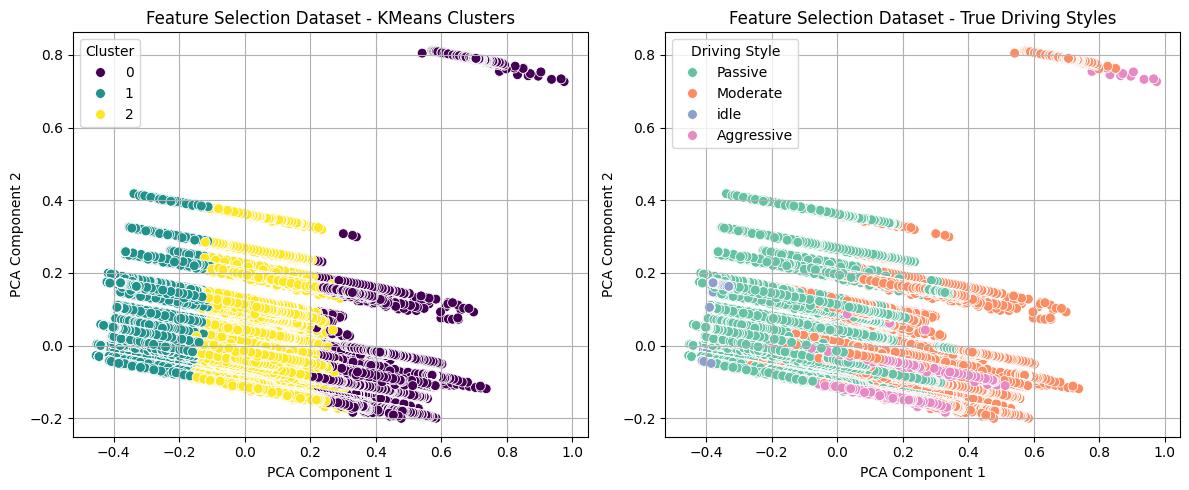

<ipython-input-11-d9addfea287a>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_filled = X.fillna(method='ffill').dropna()



==== Feature Engineering Dataset ====
Silhouette Score: 0.444
Adjusted Rand Index (ARI): 0.125
Normalized Mutual Info (NMI): 0.239


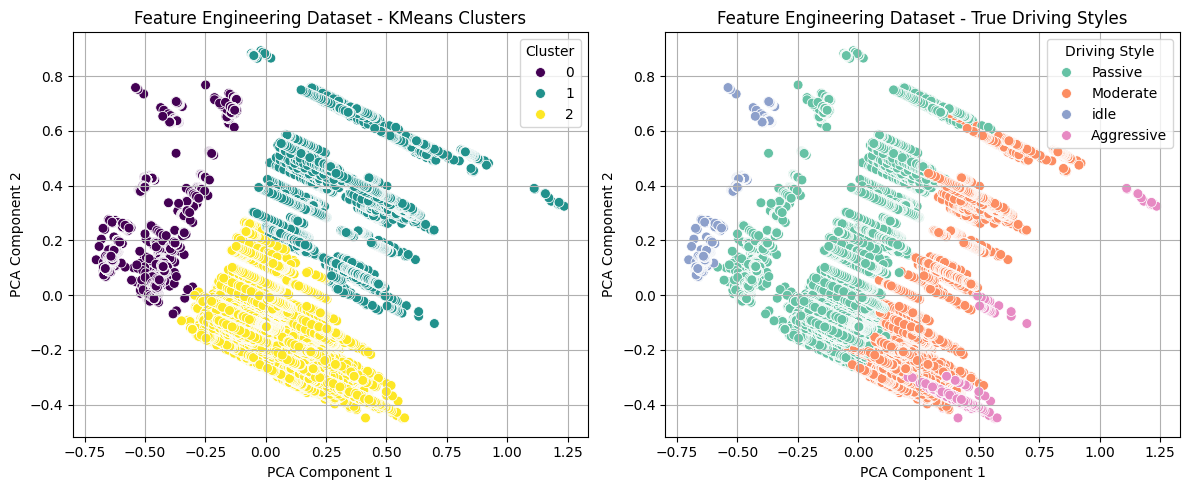

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
import matplotlib.pyplot as plt
import seaborn as sns

def run_clustering(file_path, dataset_name, k=3):
    # Load dataset
    df = pd.read_csv(file_path)

    if 'driving_style' not in df.columns:
        raise ValueError("Dataset must include 'driving_style' column.")

    # Separate features and labels
    y_true = df['driving_style']
    X = df.drop(columns=['driving_style'])

    # Fill and drop missing values
    df_filled = X.fillna(method='ffill').dropna()
    X = df_filled
    y_true = y_true.loc[X.index].reset_index(drop=True)

    # Scale features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Evaluation
    silhouette = silhouette_score(X_scaled, cluster_labels)
    ari = adjusted_rand_score(y_true, cluster_labels)
    nmi = normalized_mutual_info_score(y_true, cluster_labels)

    print(f"\n==== {dataset_name} ====")
    print(f"Silhouette Score: {silhouette:.3f}")
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Info (NMI): {nmi:.3f}")

    # Visualization
    plt.figure(figsize=(12, 5))

    # Plot KMeans clusters
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', s=50)
    plt.title(f"{dataset_name} - KMeans Clusters")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Cluster')
    plt.grid(True)

    # Plot actual driving styles
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_true, palette='Set2', s=50)
    plt.title(f"{dataset_name} - True Driving Styles")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.legend(title='Driving Style')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return for inspection
    df_result = X.copy()
    df_result['cluster'] = cluster_labels
    df_result['driving_style'] = y_true
    return df_result

# Run clustering on Feature Selection dataset
result_selection = run_clustering('/content/feature_selection.csv', 'Feature Selection Dataset')

# Run clustering on Feature Engineering dataset
result_engineering = run_clustering('/content/featured_engineering.csv', 'Feature Engineering Dataset')
